In [352]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [353]:
path = os.path.dirname(os.path.abspath('Code'))
files = os.listdir(path)

In [354]:
dict = {}
for f in files:
    if f[-3:] == 'pkl' and f != "DataAnalysis.pkl":
        tempdf = pd.read_pickle('./'+f)
        dict[f[:-4]] = tempdf

In [355]:
dict.keys()
bit_df = dict["bitcoin_price"]

In [356]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from numpy import log

## Bitcoin dataset

### Determining stationarity (`d`)

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (`adfuller()`), from the statsmodels package.

  **Because, you need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.**

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [357]:
result = adfuller(bit_df["Close"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.889418
p-value: 0.002114


Since p-value is lower than the significance level, we can safely assume that the time series is stationary and can set `d` to a value of **0**.

### Determining the order of the AR term (`p`)

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (**PACF**) plot.

Partial autocorrelation can be imagined as the **correlation between the series and its lag, after excluding the contributions from the intermediate lags**

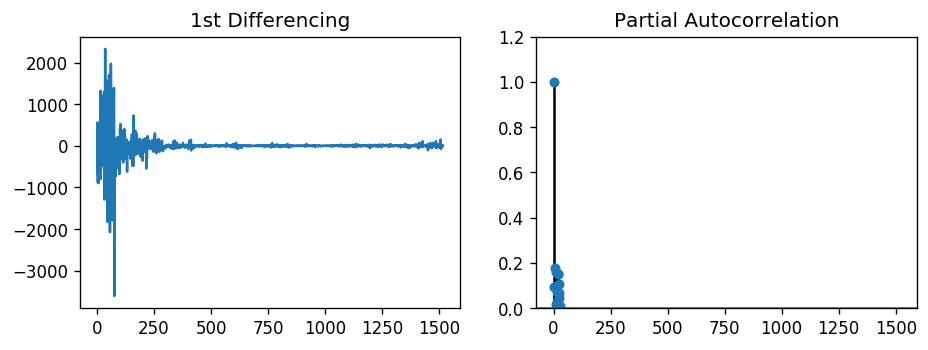

In [358]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

temp = bit_df[["Close"]].reset_index(drop=True)

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(temp["Close"].diff().dropna()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
# axes[1].set(xlim=(0,25))
plot_pacf(temp["Close"].diff().dropna(), ax=axes[1])

plt.show()

We can observe that the PACF lag 1 is quite significant since is well above the significance line compared to other values. Hence, we can safely set `p` to **1**.

### Determining the order of the MA term (`q`)

Just like how we looked at the PACF plot for the number of AR terms, you can look at the **ACF** plot for the number of MA terms. 

**An MA term is technically, the error of the lagged forecast**.

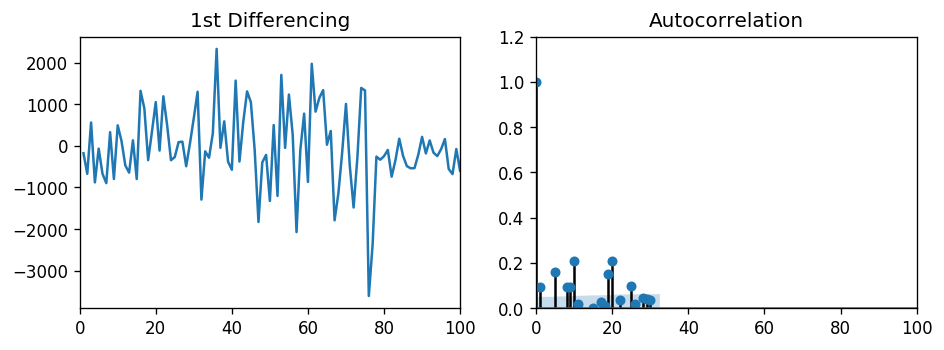

In [359]:
# The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(temp["Close"].diff().dropna()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
axes[1].set(xlim=(0,100))
plot_acf(temp["Close"].diff().dropna(), ax=axes[1])

plt.show()

Count the number of lags that are well above the significance line. So, let’s tentatively fix `q` as **8**.

### Building the ARIMA Model

After determining the ARIMA parameters (`p`, `q` and `d`), we can start building the model.

### Building the model

In [360]:
# p = 1   d = 0   q = 8
model = ARIMA(temp["Close"], order=(1,0,8))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1517
Model:                     ARMA(1, 8)   Log Likelihood              -10456.083
Method:                       css-mle   S.D. of innovations            237.803
Date:                Thu, 05 Dec 2019   AIC                          20934.166
Time:                        18:28:12   BIC                          20992.736
Sample:                             0   HQIC                         20955.973
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1066.5782   3208.530      0.332      0.740   -5222.026    7355.182
ar.L1.Close     0.9964      0.004    267.216      0.000       0.989       1.004
ma.L1.Close     0.0952      0.027      3.585    

We can notice that the p-value in `P > |z|` for the MA terms are much less than 0.05. Hence, we can ideally drop a few MA terms. Let's set `q` to **3** and rebuild the model.

In [361]:
# p = 1   d = 0   q = 3
model = ARIMA(temp["Close"], order=(1,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1517
Model:                     ARMA(1, 3)   Log Likelihood              -10501.051
Method:                       css-mle   S.D. of innovations            245.029
Date:                Thu, 05 Dec 2019   AIC                          21014.102
Time:                        18:28:14   BIC                          21046.049
Sample:                             0   HQIC                         21025.996
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1684.0996   3863.899      0.436      0.663   -5889.003    9257.202
ar.L1.Close     0.9984      0.002    500.671      0.000       0.994       1.002
ma.L1.Close     0.1077      0.026      4.079    

### Evaluating the model

In [362]:
X = bit_df["Close"].values
size = int(len(X) * 0.80)
predictions = model_fit.predict(size,len(X)-1)

test = X[size:len(X)]
error = mean_squared_error(test, predictions)
error

575.2406751067899

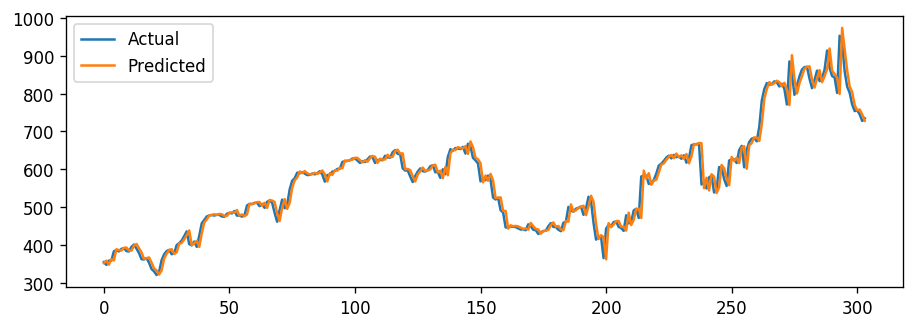

In [372]:
plt.plot(test, label="Actual")
plt.plot(predictions.reset_index(drop=True), label="Predicted")
plt.legend()
plt.show()

## Ethereum Dataset

In [404]:
eth_df = dict["ethereum_price"]

### Determining stationarity (`d`)

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (`adfuller()`), from the statsmodels package.

  **Because, you need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.**

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [405]:
result = adfuller(eth_df["Close"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.476389
p-value: 0.000217


Since p-value is lower than the significance level, we can safely assume that the time series is stationary and can set `d` to a value of **0**.

### Determining the order of the AR term (`p`)

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (**PACF**) plot.

Partial autocorrelation can be imagined as the **correlation between the series and its lag, after excluding the contributions from the intermediate lags**

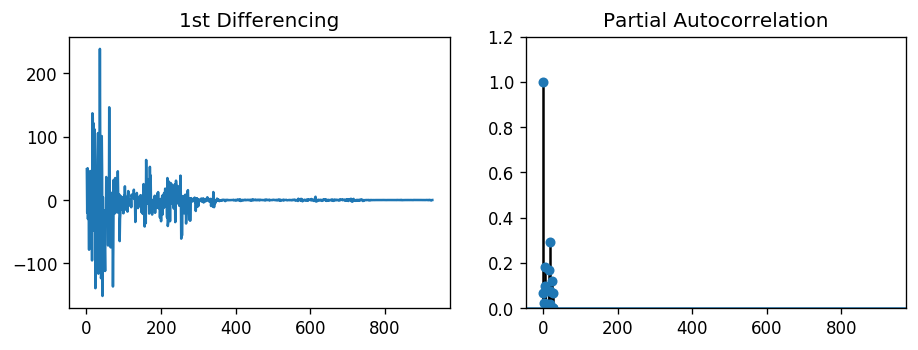

In [406]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

temp = eth_df[["Close"]].reset_index(drop=True)

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(temp["Close"].diff().dropna()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
# axes[1].set(xlim=(0,25))
plot_pacf(temp["Close"].diff().dropna(), ax=axes[1])

plt.show()

We can observe that the PACF lag 1 is quite significant since is well above the significance line compared to other values. Hence, we can safely set `p` to **1**.

### Determining the order of the MA term (`q`)

Just like how we looked at the PACF plot for the number of AR terms, you can look at the **ACF** plot for the number of MA terms. 

**An MA term is technically, the error of the lagged forecast**.

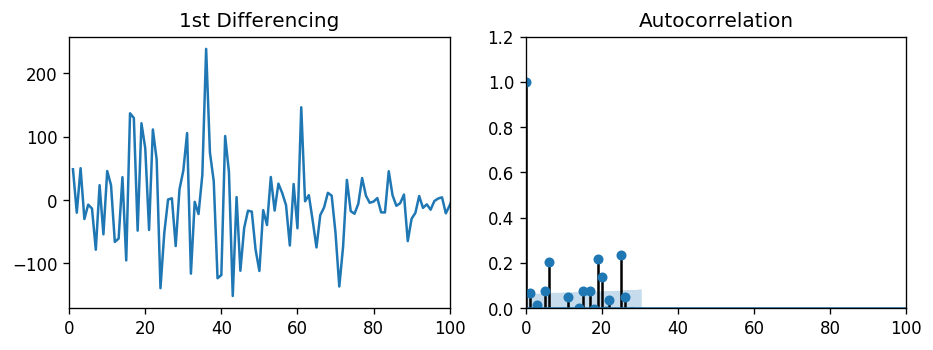

In [407]:
# The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(temp["Close"].diff().dropna()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
axes[1].set(xlim=(0,100))
plot_acf(temp["Close"].diff().dropna(), ax=axes[1])

plt.show()

Count the number of lags that are well above the significance line. So, let’s tentatively fix `q` as **4**.

### Building the ARIMA Model

After determining the ARIMA parameters (`p`, `q` and `d`), we can start building the model.

### Building the model

In [408]:
# p = 1   d = 0   q = 8
model = ARIMA(temp["Close"], order=(1,0,4))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  928
Model:                     ARMA(1, 4)   Log Likelihood               -4197.157
Method:                       css-mle   S.D. of innovations             22.214
Date:                Thu, 05 Dec 2019   AIC                           8408.314
Time:                        19:40:19   BIC                           8442.145
Sample:                             0   HQIC                          8421.219
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         327.5307    305.506      1.072      0.284    -271.250     926.311
ar.L1.Close     0.9984      0.002    606.049      0.000       0.995       1.002
ma.L1.Close     0.0875      0.032      2.731    

We can notice that the p-value in `P > |z|` for the MA terms more than 0.05 for 3rd and 4th MA terms. Hence, we can ideally drop a few MA terms and rebuild the model. Let's set `q` to **2** and 

In [409]:
# p = 1   d = 0   q = 2
model = ARIMA(temp["Close"], order=(1,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  928
Model:                     ARMA(1, 2)   Log Likelihood               -4203.347
Method:                       css-mle   S.D. of innovations             22.365
Date:                Thu, 05 Dec 2019   AIC                           8416.694
Time:                        19:40:21   BIC                           8440.859
Sample:                             0   HQIC                          8425.911
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         309.6515    287.355      1.078      0.281    -253.554     872.857
ar.L1.Close     0.9982      0.002    548.625      0.000       0.995       1.002
ma.L1.Close     0.0810      0.033      2.440    

In [410]:
X = eth_df["Close"].values
size = int(len(X) * 0.80)
predictions = model_fit.predict(size,len(X)-1)

test = X[size:len(X)]
error = mean_squared_error(test, predictions)
error

0.34081758439450305

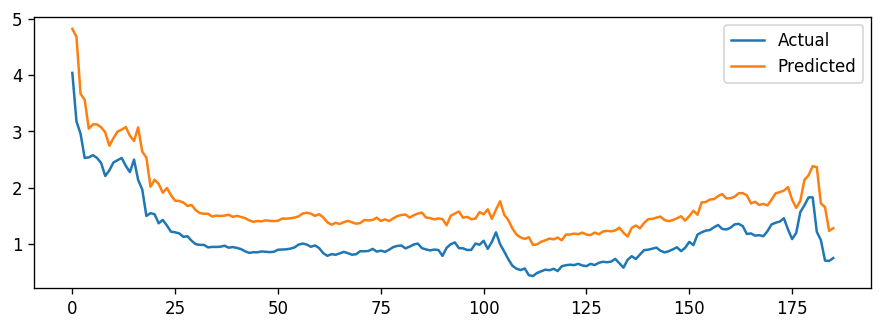

In [412]:
plt.plot(test, label="Actual")
plt.plot(predictions.reset_index(drop=True), label="Predicted")
plt.legend()
plt.show()